# Nettoyage du texte

## Importation des librairies

In [19]:
import pandas as pd
import nltk
import string
from nltk.stem import WordNetLemmatizer
import numpy as np
import re
from sklearn import preprocessing
from seaborn import countplot

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinelv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/justinelv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/justinelv/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/justinelv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Chargement des données 

In [3]:
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
pd.options.display.max_colwidth = 50

df = pd.read_csv('./csv/cleaned.csv')

In [4]:
df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,...,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",...,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",...,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",...,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

## Sélection des colonnes utiles

In [6]:
df_process = df[['uniq_id','product_name','description','product_category_tree']].copy()
df_process.head(1)

,uniq_id,product_name,description,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>..."


## Nettoyage des données textes

### Fonction pour nettoyer les données 

In [7]:
# pour enlever la ponctuation
ponctuations = string.punctuation + '�' + '°' + '…' + '±' + '•' + '’' + '–' + '“' + '”' 
# stopwords, ce sont les mots qui apparaissent très fréquemment mais qui n’apporte pas de sens à la phrase (comme « de », « le », « une »)
stopwords = nltk.corpus.stopwords.words('english')
stopwords_custom = stopwords
stopwords_custom.append('yes')
# mots (words) qui proviennent d’un dictionnaire anglais (directement intégré à la librairie nltk)
words = set(nltk.corpus.words.words())
# un lemmatizer, cette objet nous permet de préserver la racine des mots de tel sorte que deux mots ayant une même souche seront considérés comme un seul et même mot 
lemmatizer = WordNetLemmatizer()

In [8]:
def text_prepocessing(df):
    
    preprocess_list = []
    
    for sentence in df :
        
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in ponctuations])

        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())

        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)

        words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords_custom]

        words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)

        sentence_clean = ' '.join(w for w in words_lemmatize if w.lower() in words or not w.isalpha())
        
        remove_one_two_letters_word = re.sub(r'\b[a-zA-Z]{1,2}(?=\s|$)','',sentence_clean)
        
        preprocess_list.append(remove_one_two_letters_word)
        
    return preprocess_list 

In [9]:
def text_prepocessing_product_name(df):
    
    preprocess_list = []
    
    for sentence in df :
        
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in ponctuations])

        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())

        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)

        words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords_custom]

        words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)

        sentence_clean = ' '.join(w for w in words_lemmatize)
        
        remove_one_two_letters_word = re.sub(r'\b[a-zA-Z]{1,2}(?=\s|$)','',sentence_clean)
        
        preprocess_list.append(remove_one_two_letters_word)
        
    return preprocess_list 

Le product name est nettoyer avec une fonction légèrement différente, les motes ne doivent pas faire partie de la liste words car certain mot n'y sont pas et cela crée des lignes vide.

### Nettoyage de la colonne description

In [10]:
description_clean = text_prepocessing(df_process['description'])

In [11]:
df_process['description_clean'] = description_clean
df_process['description_clean'][0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor abstract eyelet door curtain height pack price  curtain look curtain made high quality polyester feature eyelet style stitch metal make room environment romantic curtain ant wrinkle anti shrinkage elegant home bright modernistic appeal design attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model  duster color multicolor dimension length box number content sale package pack sale package curtain body design material polyester'

### Nettoyage de la colonne product_name

In [12]:
product_name_clean = text_prepocessing_product_name(df_process['product_name'])

In [13]:
df_process['product_name_clean'] = product_name_clean
df_process['product_name_clean'][0]

'elegance polyester multicolor abstract eyelet door curtain'

### Création des labels

Pour extraire les catégories du la colonne 'product_category_tree', j'ai testé de prendre la première catégorie et la sous catégorie pour voir si il y en avait une mieux que l'autre pour réprésenter nos groupes de produits.

In [14]:
# définir une fonction lambda pour extraire la catégorie principale
extract_category = lambda x: x.split(">>")[0].strip().strip(']["')

# appliquer la fonction à la colonne 'product_category_tree' du DataFrame
df_process['main_category'] = df_process['product_category_tree'].apply(extract_category)
df_process['main_category'][0]

'Home Furnishing'

In [15]:
# définir une fonction lambda pour extraire la sous-catégorie
extract_sub_category = lambda x: x.split(">>")[1].strip(' "').strip(' "]\'')

# appliquer la fonction à la colonne 'product_category_tree' du DataFrame
df_process['sub_category'] = df_process['product_category_tree'].apply(extract_sub_category)
df_process['sub_category'][0]

'Curtains & Accessories'

Text(0.5, 1.0, 'Data Distribution')

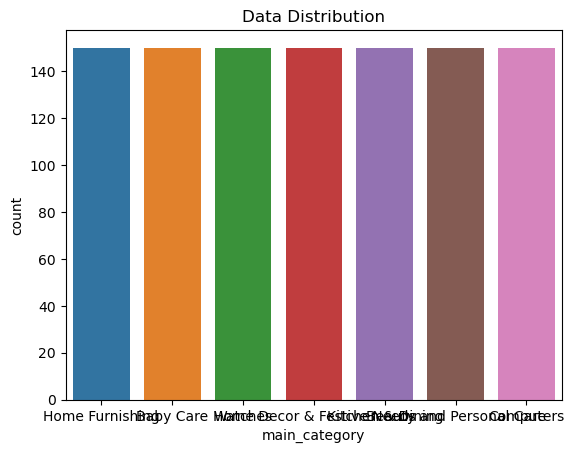

In [16]:
countplot(x='main_category',data=df_process).set_title("Data Distribution")

Text(0.5, 1.0, 'Data Distribution')

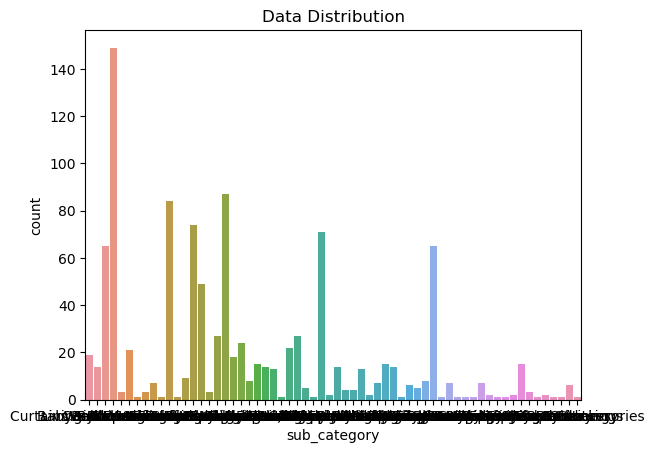

In [17]:
countplot(x='sub_category',data=df_process).set_title("Data Distribution")

Les catégories représentées dans la colonne main_category sont mieux réparties que les cotégories de la colonne sub_category. La colonne main_category sera donc choisit pour être le label.

In [20]:
label_encoder = preprocessing.LabelEncoder()
label_encoder .fit(df_process['main_category'])
df_process['main_category_num']=label_encoder.transform(df_process['main_category'])
df_process

,uniq_id,product_name,description,product_category_tree,description_clean,product_name_clean,main_category,sub_category,main_category_num
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",key feature elegance polyester multicolor abst...,elegance polyester multicolor abstract eyelet ...,Home Furnishing,Curtains & Accessories,4
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",specification cotton bath towel bath towel red...,sathiyas cotton bath towel,Baby Care,Baby Bath & Skin,0
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",key feature cotton terry face towel set size s...,eurospa cotton terry face towel set,Baby Care,Baby Bath & Skin,0
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature royal fashion cotton printed king ...,santosh royal fashion cotton printed king size...,Home Furnishing,Bed Linen,4
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature print cotton floral king sized dou...,jaipur print cotton floral king sized double b...,Home Furnishing,Bed Linen,4
...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",empower extra large self adhesive sticker pack...,oren empower extra large self adhesive sticker,Baby Care,Baby & Kids Gifts,0
1046,fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",large vinyl sticker sticker pack price bring ...,wallmantra large vinyl sticker sticker,Baby Care,Baby & Kids Gifts,0
1047,5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",buy extra large polyvinyl film sticker extra ...,uberlyfe extra large pigmented polyvinyl film ...,Baby Care,Baby & Kids Gifts,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",buy medium vinyl sticker sticker medium vinyl...,wallmantra medium vinyl sticker sticker,Baby Care,Baby & Kids Gifts,0


Text(0.5, 1.0, 'Data Distribution')

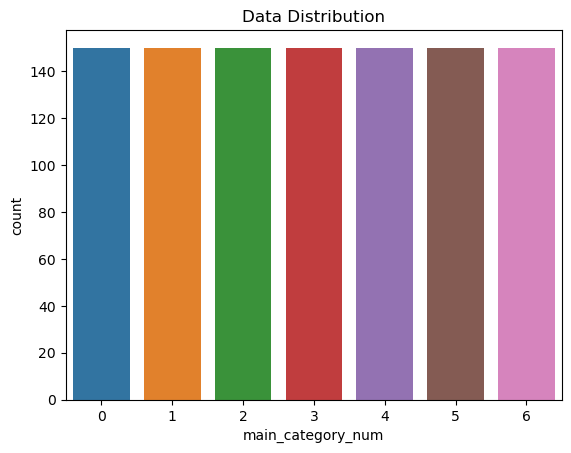

In [21]:
countplot(x='main_category_num',data=df_process).set_title("Data Distribution")

# Création du dataframe avec les données nettoyées

In [22]:
df_clean_text = df_process[['uniq_id','product_name_clean','description_clean','main_category','main_category_num' ]].copy()
df_clean_text

,uniq_id,product_name_clean,description_clean,main_category,main_category_num
0,55b85ea15a1536d46b7190ad6fff8ce7,elegance polyester multicolor abstract eyelet ...,key feature elegance polyester multicolor abst...,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,sathiyas cotton bath towel,specification cotton bath towel bath towel red...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,eurospa cotton terry face towel set,key feature cotton terry face towel set size s...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,santosh royal fashion cotton printed king size...,key feature royal fashion cotton printed king ...,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,jaipur print cotton floral king sized double b...,key feature print cotton floral king sized dou...,Home Furnishing,4
...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,oren empower extra large self adhesive sticker,empower extra large self adhesive sticker pack...,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c,wallmantra large vinyl sticker sticker,large vinyl sticker sticker pack price bring ...,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009,uberlyfe extra large pigmented polyvinyl film ...,buy extra large polyvinyl film sticker extra ...,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,wallmantra medium vinyl sticker sticker,buy medium vinyl sticker sticker medium vinyl...,Baby Care,0


In [23]:
# J'ajoute une colonne qui ajoute description_clean et product_name_clean pour obtenir plus d'infos en une colonne
df_clean_text['description_name'] = df_clean_text.description_clean + df_clean_text.product_name_clean
df_clean_text.description_name[0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor abstract eyelet door curtain height pack price  curtain look curtain made high quality polyester feature eyelet style stitch metal make room environment romantic curtain ant wrinkle anti shrinkage elegant home bright modernistic appeal design attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model  duster color multicolor dimension length box number content sale package pack sale package curtain body design material polyesterelegance polyester multicolor abstract eye

In [24]:
df_clean_text.to_csv('./csv/test_clean.csv')